# Project

## 0. Introduction

### Imports

We start by importing all the libraries used in this project.

In [1]:
from gemseo.algos.parameter_space import ParameterSpace
from gemseo.core.mdo_scenario import MDOScenario

from gemseo.algos.design_space import DesignSpace
from numpy import array

from gemseo.api import configure_logger

# discipline
from gemseo.api import create_discipline
from gemseo_mlearning.api import sample_discipline

from gemseo.uncertainty.sensitivity.sobol.analysis import SobolAnalysis

from MARILib_obj_edu.marilib.utils import unit

from gemseo.api import create_design_space
from gemseo.api import create_parameter_space
from gemseo.api import create_surrogate
from gemseo.api import create_scenario

from gemseo.mlearning.qual_measure.r2_measure import R2Measure
from gemseo.mlearning.qual_measure.rmse_measure import RMSEMeasure

%load_ext autoreload
%autoreload 2

### Classes & Function

The goal is to minimize the Maximum Take-Off Weight which is one of the outputs of the following function.

In [3]:
from h2_turbofan.turbofan_h2_class import H2TurboFan
disc = H2TurboFan()

However, that function is costly to execute. Thus, we will create a surrogate model that approximates it well enough to run an optimization problem.

Then, we create some classes depending on the Subproblem.

In [4]:
class XVar_UDefault(DesignSpace):
    def __init__(self):
        super().__init__()
        self.thrust = self.add_variable('thrust', value=unit.N_kN(121), l_b=unit.N_kN(100), u_b=unit.N_kN(150))
        self.bpr = self.add_variable('bpr', value=9, l_b=5, u_b=12)
        self.area = self.add_variable('area', value=164, l_b= 120, u_b=200)
        self.aspect_ratio = self.add_variable('aspect_ratio', value=9, l_b=7 , u_b=12)

class XDefault_UVar(ParameterSpace):
    def __init__(self):
        super().__init__()
        self.drag = self.add_random_variable("drag", "OTTriangularDistribution", minimum=0.8, mode=0.845, maximum=0.85)
        self.sfc = self.add_random_variable("sfc", "OTTriangularDistribution", minimum=0.99, mode=1, maximum=1.03)
        self.mass = self.add_random_variable("mass", "OTTriangularDistribution", minimum=0.99, mode=1, maximum=1.03)
        self.tvi = self.add_random_variable("tvi", "OTTriangularDistribution", minimum=0.25, mode=0.3, maximum=0.305)
        self.tgi = self.add_random_variable("tgi", "OTTriangularDistribution", minimum=0.99, mode=1, maximum=1.03)

class XVar_Uvar(ParameterSpace):
    def __init__(self):
        super().__init__()
        self.thrust = self.add_variable('thrust', value=unit.N_kN(121), l_b=unit.N_kN(100), u_b=unit.N_kN(150))
        self.bpr = self.add_variable('bpr', value=9, l_b=5, u_b=12)
        self.area = self.add_variable('area', value=164, l_b= 120, u_b=200)
        self.aspect_ratio = self.add_variable('aspect_ratio', value=9, l_b=7 , u_b=12)
        self.drag = self.add_random_variable("drag", "OTTriangularDistribution", minimum=0.8, mode=0.845, maximum=0.85)
        self.sfc = self.add_random_variable("sfc", "OTTriangularDistribution", minimum=0.99, mode=1, maximum=1.03)
        self.mass = self.add_random_variable("mass", "OTTriangularDistribution", minimum=0.99, mode=1, maximum=1.03)
        self.tvi = self.add_random_variable("tvi", "OTTriangularDistribution", minimum=0.25, mode=0.3, maximum=0.305)
        self.tgi = self.add_random_variable("tgi", "OTTriangularDistribution", minimum=0.99, mode=1, maximum=1.03)

## I. Sub-Problem 1

We will create a surrogate model of $g: x \mapsto g(x)=f\left(x, u_{\text {default }}\right)$ to approximate the objective and constraints of the design problem with respect to the design parameters $x$. Then, we will use this surrogate model in an optimization process to minimize the objective whilst ensuring the constraints by varying the design parameters.

### I.1. Creating the surrogate model

We start by creating a discipline with a DesignSpace XVar_UDefault (x varies, u is default), 30 points are computed.

In [5]:
# we sample the discipline with an optimal LHS
dataset = sample_discipline(disc,
                            XVar_UDefault(),
                            ['mtow', 'tofl', 'vapp', 'vz_mcl', 'vz_mcr', 'oei_path', 'ttc', 'far', 'fuel', 'coc'],
                            "OT_OPT_LHS",
                            30)

Visualization of the dataframe:

In [6]:
dataset.export_to_dataframe().head()

inputs                              outputs                          \
         area aspect_ratio        bpr          coc        far         fuel   
            0            0          0            0          0            0   
0  181.732355    11.152984   8.598392  5832.251079  13.162013  1000.800165   
1  149.097877    10.235819   6.376335  5813.753855  13.431645  1078.221218   
2  191.088518     7.112854  10.601939  5843.331995  13.382362  1063.623379   
3  133.169629     8.574760   6.753216  5811.329978  13.555785  1115.447542   
4  152.745782     7.805918   8.434007  5790.167727  13.347153  1051.003446   

                                  inputs      outputs                          \
           mtow  oei_path         thrust         tofl          ttc       vapp   
              0         0              0            0            0          0   
0  87079.990208  0.018575  123208.448413  2075.510800  1134.302479  67.415304   
1  85979.659180  0.015757  124284.117693  2396.998472  1114.291112  73.732146   
2  87963.623902  0.009470  125042.124386  2299.249773  1358.108322  65.943114   
3  85915.431781  0.017282  138790.140037  2357.908443   994.910274  77.886921   
4  84348.374296  0.008963  119637.673548  2534.107936  1322.755017  72.186750   

                       
     vz_mcl    vz_mcr  
          0         0  
0  5.183569  0.938291  
1  5.673349  1.351176  
2  3.683279 -1.074904  
3  6.626287  1.933965  
4  4.165944 -0.514140

Therefore, we can create a surrogate model by using, for example, a Gaussian Process Regressor to fit the new data points.

In [7]:
surrogate_model = create_surrogate("GaussianProcessRegressor", data=dataset)

With the surrogate model created, we can compute some statistics to check how well it fits the data:

In [8]:
r2 = R2Measure(surrogate_model.regression_model, True)

print(r2.evaluate_learn())  # learning measure
print(r2.evaluate_kfolds())  # k-folds cross-validation measure

rmse = RMSEMeasure(surrogate_model.regression_model, True)
print(rmse.evaluate_learn())
print(rmse.evaluate_kfolds())

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
[0.99131695 0.98728363 0.98776614 0.9909871  0.99409167 0.76471321
 0.89135741 0.99238922 0.99393729 0.99208108]
[8.45003972e-07 6.90333361e-09 1.97339352e-06 6.09464366e-05
 7.47782479e-11 2.79047237e-05 8.13849759e-06 4.42763875e-08
 1.69767213e-08 1.99666146e-08]
[5.90984152e+00 4.78934648e-02 1.35953475e+01 4.22239868e+02
 6.36415485e-04 3.27838168e+02 1.16897278e+02 3.59663045e-01
 1.42607569e-01 1.66270529e-01]


### I.2. Optimization problem

In [9]:
configure_logger()

<RootLogger root (INFO)>

Now that the surrogate model is created, we can create an optimization problem with its constraints. Let's remember that the goal is to minimize MTOW.

In [10]:
# # does not work ?
# class XVar_UDefault_opti(MDOScenario):
#     def __init__(self):
#         self.tolf = self.add_constraint('tolf', constraint_type='ineq', positive=True, value=2200)
#         self.vapp = self.add_constraint('vapp', constraint_type='ineq', positive=True, value=137)
#         self.vz_mcl = self.add_constraint('vz_mcl', constraint_type='ineq', positive=False, value=unit.ftpmin_mps(300))
#         self.vz_mcr = self.add_constraint('vz_mcr', constraint_type='ineq', positive=False, value=unit.ftpmin_mps(0))
#         self.oei_path = self.add_constraint('oei_path', constraint_type='ineq', positive=False, value=0.011)
#         self.ttc = self.add_constraint('ttc', constraint_type='ineq', positive=True, value=unit.min_s(25))
#         self.far = self.add_constraint('far', constraint_type='ineq', positive=True, value=13.4)


In [11]:
scenario = create_scenario(surrogate_model,
                            'DisciplinaryOpt',
                            ['mtow'],
                            XVar_UDefault())

scenario.add_constraint(output_name='tofl', constraint_type='ineq', positive=False, value=4200)                      
scenario.add_constraint(output_name='vapp', constraint_type='ineq', positive=False, value=137)
scenario.add_constraint(output_name='vz_mcl', constraint_type='ineq', positive=True, value=unit.mps_ftpmin(300))
scenario.add_constraint(output_name='vz_mcr', constraint_type='ineq', positive=True, value=unit.mps_ftpmin(0))
scenario.add_constraint(output_name='oei_path', constraint_type='ineq', positive=True, value=0.011)
scenario.add_constraint(output_name='ttc', constraint_type='ineq', positive=False, value=unit.s_min(25))
scenario.add_constraint(output_name='far', constraint_type='ineq', positive=False, value=13.4)

Execute the optimization problem:

https://gemseo.readthedocs.io/en/stable/algorithms/opt_algos.html

In [12]:
scenario.execute({'algo': 'PDFO_COBYLA', 'max_iter': 300, 'normalize_design_space':True})

    INFO - 14:28:18:  
    INFO - 14:28:18: *** Start MDOScenario execution ***
    INFO - 14:28:18: MDOScenario
    INFO - 14:28:18:    Disciplines: Surrogate discipline: GPR_H2TurboFan
    INFO - 14:28:18:    Dataset name: H2TurboFan
    INFO - 14:28:18:    Dataset size: 30
    INFO - 14:28:18:    Surrogate model: GaussianProcessRegressor
    INFO - 14:28:18:    Inputs: area, aspect_ratio, bpr, thrust
    INFO - 14:28:18:    Outputs: coc, far, fuel, mtow, oei_path, tofl, ttc, vapp, vz_mcl, vz_mcr
    INFO - 14:28:18:    MDO formulation: DisciplinaryOpt
    INFO - 14:28:18: Optimization problem:
    INFO - 14:28:18:    minimize mtow(thrust, bpr, area, aspect_ratio)
    INFO - 14:28:18:    with respect to area, aspect_ratio, bpr, thrust
    INFO - 14:28:18:    subject to constraints:
    INFO - 14:28:18:       tofl(thrust, bpr, area, aspect_ratio) <= 2200
    INFO - 14:28:18:       vapp(thrust, bpr, area, aspect_ratio) <= 137
    INFO - 14:28:18:       vz_mcl(thrust, bpr, area, aspect_

{'max_iter': 300, 'algo': 'PDFO_COBYLA'}

Some visualizations:

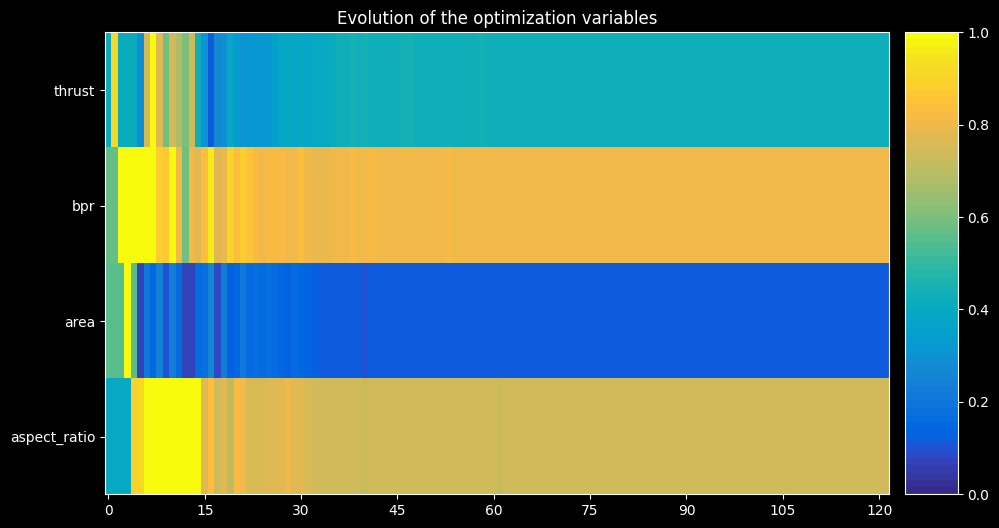

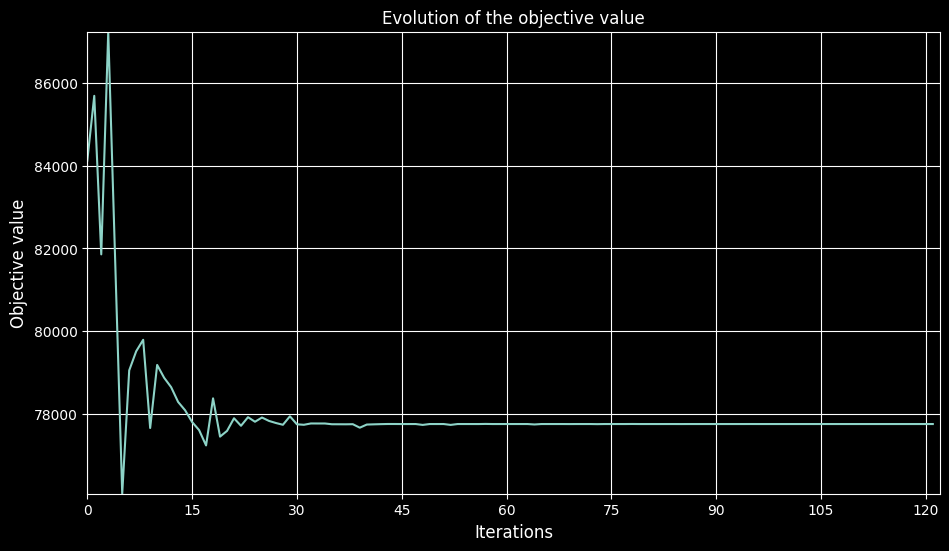

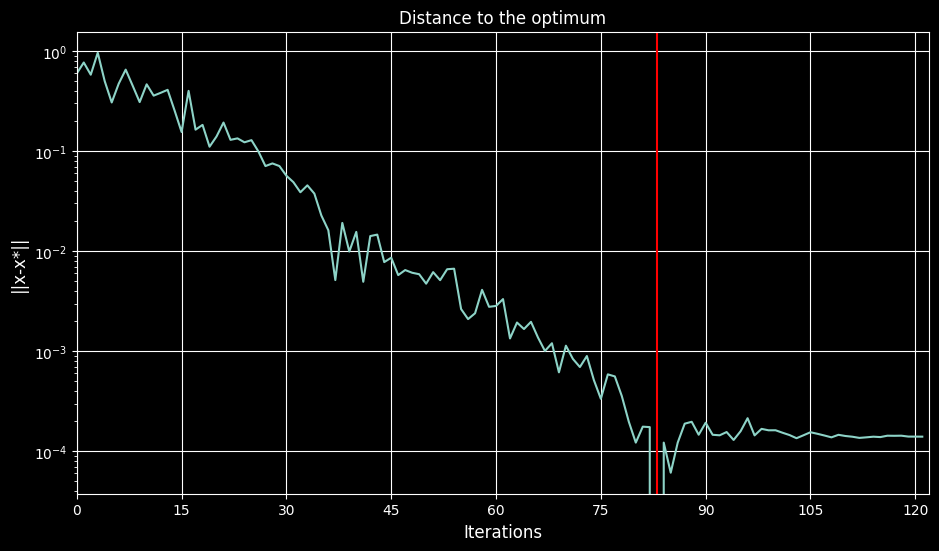

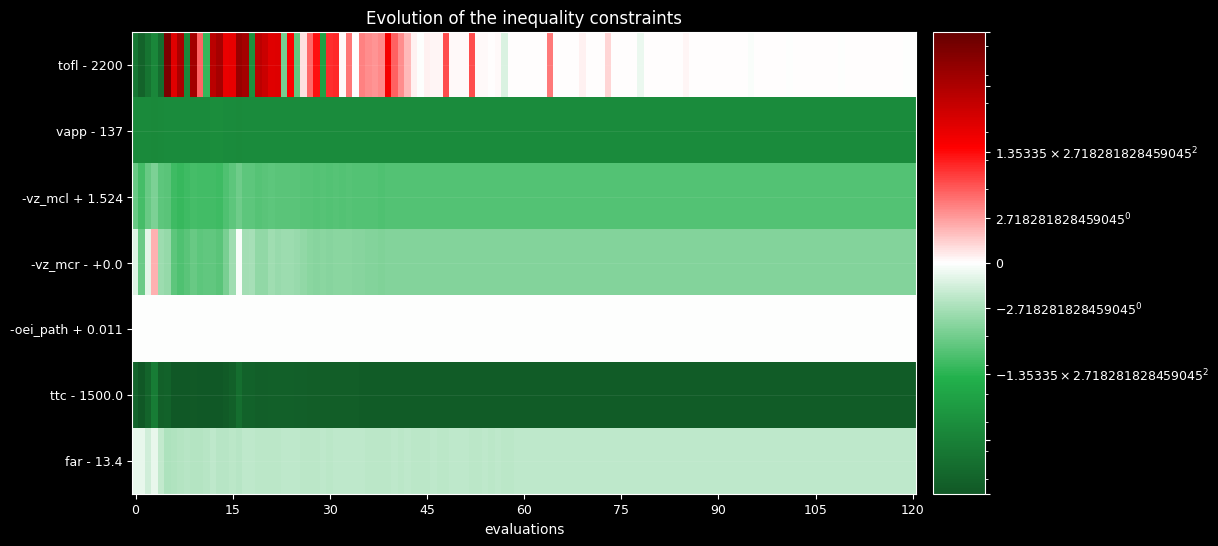

In [13]:
import matplotlib.pyplot as plt
scenario.post_process("OptHistoryView", save=False, show=False)
plt.show()

## II. Sub-Problem 2

## III. Sub-Problem 3